# Classification

In [16]:
from IPython.display import SVG, display

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from megabouts.tracking_data import TrackingConfig,load_example_data,FullTrackingData

from megabouts.config import TailPreprocessingConfig,TrajPreprocessingConfig
from megabouts.preprocessing import TailPreprocessing,TrajPreprocessing

from megabouts.config import TailSegmentationConfig
from megabouts.segmentation import TailSegmentation,Segmentation

from megabouts.classification import TailBouts,BoutClassifier


In [17]:
import torch
# Force cpu use:
torch.cuda.is_available = lambda : False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [18]:
df_recording, fps, mm_per_unit = load_example_data('fulltracking_posture')

tracking_cfg = TrackingConfig(fps=fps, tracking='full_tracking')

head_x = df_recording['head_x'].values*mm_per_unit
head_y = df_recording['head_y'].values*mm_per_unit
head_yaw = df_recording['head_angle'].values
tail_angle = df_recording.filter(like='tail_angle').values

tracking_data = FullTrackingData.from_posture(head_x = head_x,
                                              head_y = head_y,
                                              head_yaw = head_yaw,
                                              tail_angle = tail_angle)

tail_preprocessing_cfg = TailPreprocessingConfig(fps=tracking_cfg.fps)
tail_df_input = tracking_data.tail_df
tail = TailPreprocessing(tail_preprocessing_cfg).preprocess_tail_df(tail_df_input)

traj_preprocessing_cfg = TrajPreprocessingConfig(fps=tracking_cfg.fps)
traj_df_input = tracking_data.traj_df
traj = TrajPreprocessing(traj_preprocessing_cfg).preprocess_traj_df(traj_df_input)

In [19]:
tail.df.head(5)

angle                                                              \
   segments                                                               
          0         1         2         3         4         5         6   
0 -0.101865 -0.092813 -0.107645 -0.110575 -0.047699 -0.145887 -0.130414   
1 -0.082618 -0.087957 -0.096951 -0.092459 -0.119418 -0.043354 -0.099788   
2 -0.093377 -0.095235 -0.094292 -0.105936 -0.073785 -0.084193 -0.144378   
3 -0.092590 -0.083650 -0.100938 -0.088223 -0.097370 -0.099559 -0.101538   
4 -0.086849 -0.081982 -0.096705 -0.118475 -0.046264 -0.136459 -0.115412   

                           ... angle_smooth                                \
                           ...     segments                                 
          7         8   9  ...            2         3         4         5   
0 -0.058892 -0.128705 NaN  ...    -0.086812 -0.085880 -0.077907 -0.083591   
1 -0.101741 -0.171555 NaN  ...    -0.081511 -0.083338 -0.078373 -0.085253   
2 -0.112398 -0.042585 NaN  ...    -0.077037 -0.081058 -0.078500 -0.086296   
3 -0.091272 -0.021459 NaN  ...    -0.073390 -0.079040 -0.078286 -0.086720   
4 -0.085300 -0.015487 NaN  ...    -0.070570 -0.077285 -0.077732 -0.086525   

                                          vigor no_tracking  
                                                             
          6         7         8         9                    
0 -0.072974 -0.078165 -0.129616  0.000359   NaN        True  
1 -0.074040 -0.073428 -0.106065  0.000494   NaN        True  
2 -0.074570 -0.069208 -0.086540  0.000602   NaN        True  
3 -0.074562 -0.065506 -0.071041  0.000682   NaN        True  
4 -0.074018 -0.062321 -0.059569  0.000734   NaN        True  

[5 rows x 32 columns]

## Segmentation using tail vigor

In [20]:
tail_vigor = tail.vigor
tail_segmentation_cfg = TailSegmentationConfig(fps = tracking_cfg.fps,
                                               threshold=100)

In [21]:
segmentation_function = Segmentation.from_config(tail_segmentation_cfg)
segments = segmentation_function.segment(tail_vigor)



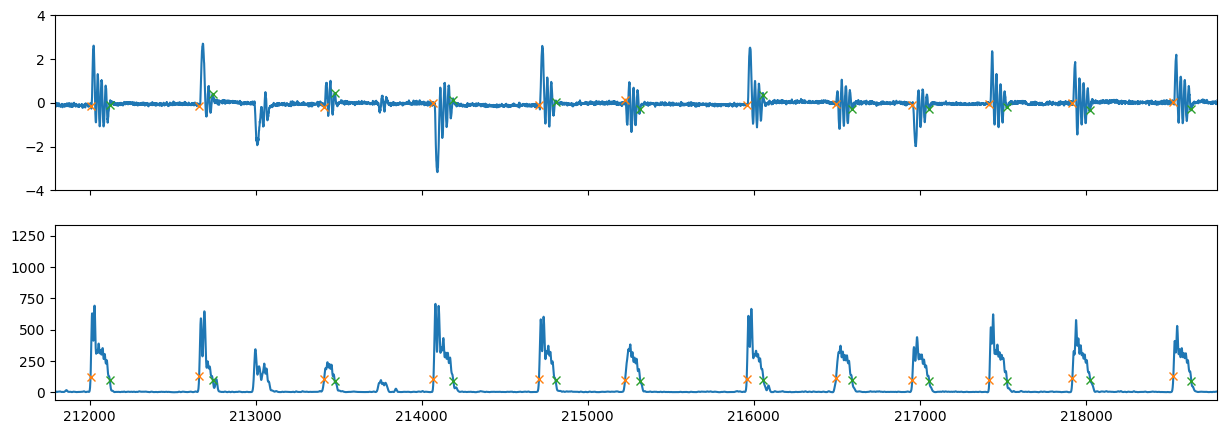

In [22]:
fig,ax = plt.subplots(2,1,figsize=(15,5),sharex=True)

x = tracking_data._tail_angle[:,7]
ax[0].plot(x)
ax[0].plot(segments.onset, x[segments.onset], "x")
ax[0].plot(segments.offset, x[segments.offset], "x")
ax[0].set_ylim(-4,4)

x = tail_vigor
ax[1].plot(x)
ax[1].plot(segments.onset, x[segments.onset], "x")
ax[1].plot(segments.offset, x[segments.offset], "x")

t = np.arange(tracking_data.T)/tracking_cfg.fps
IdSt = np.random.randint(tracking_data.T)
Duration = 10*tracking_cfg.fps
ax[1].set_xlim(IdSt,IdSt+Duration)

plt.show()

In [23]:
tail_array =  segments.extract_tail_array(tail_angle=tail.angle_smooth)
traj_array =  segments.extract_traj_array(head_x=traj.x_smooth,
                                          head_y=traj.y_smooth,
                                          head_angle=traj.yaw_smooth)

In [24]:
tail_array.shape,traj_array.shape

((745, 10, 140), (745, 3, 140))

## Running classifier on the segmented bouts

In [25]:
classifier = BoutClassifier(tracking_cfg,tail_segmentation_cfg,exclude_CS=True,device=device)
classif_results = classifier.run_classification(tail_array=tail_array,
                                                traj_array=traj_array)

E:\Code\megabouts\megabouts\megabouts\classification\classification.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(transformer_weights_p

In [26]:
segments.set_HB1(classif_results['first_half_beat'])
tail_array =  segments.extract_tail_array(tail_angle=tail.angle_smooth,
                                          align_to_onset=False)

In [27]:
segments.set_HB1(classif_results['first_half_beat'])

tail_array =  segments.extract_tail_array(tail_angle=tail.angle_smooth,
                                          align_to_onset=False)

traj_array =  segments.extract_traj_array(head_x=traj.x_smooth,
                                          head_y=traj.y_smooth,
                                          head_angle=traj.yaw_smooth,
                                          align_to_onset=False)

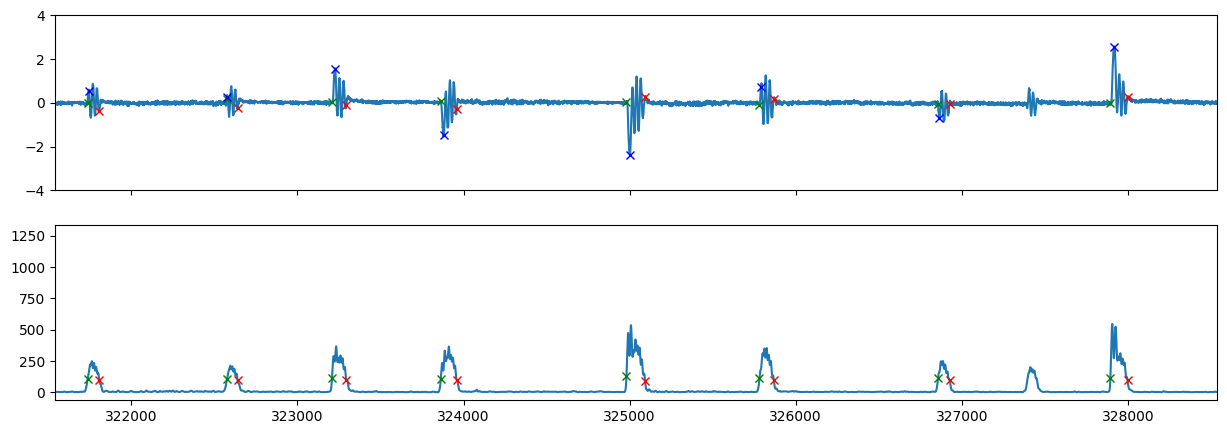

In [28]:
fig,ax = plt.subplots(2,1,figsize=(15,5),sharex=True)

x = tracking_data._tail_angle[:,7]
ax[0].plot(x)
ax[0].plot(segments.onset, x[segments.onset], "x",color='green')
ax[0].plot(segments.offset, x[segments.offset], "x",color='red')
ax[0].plot(segments.HB1, x[segments.HB1], "x",color='blue')
ax[0].set_ylim(-4,4)

x = tail_vigor
ax[1].plot(x)
ax[1].plot(segments.onset, x[segments.onset], "x",color='green')
ax[1].plot(segments.offset, x[segments.offset], "x",color='red')

t = np.arange(tracking_data.T)/tracking_cfg.fps
IdSt = np.random.randint(tracking_data.T)
Duration = 10*tracking_cfg.fps
ax[1].set_xlim(IdSt,IdSt+Duration)

plt.show()

In [29]:
# Format Output:
bouts = TailBouts(segments=segments,
                  classif_results=classif_results,
                  tail_array=tail_array,
                  traj_array=traj_array)

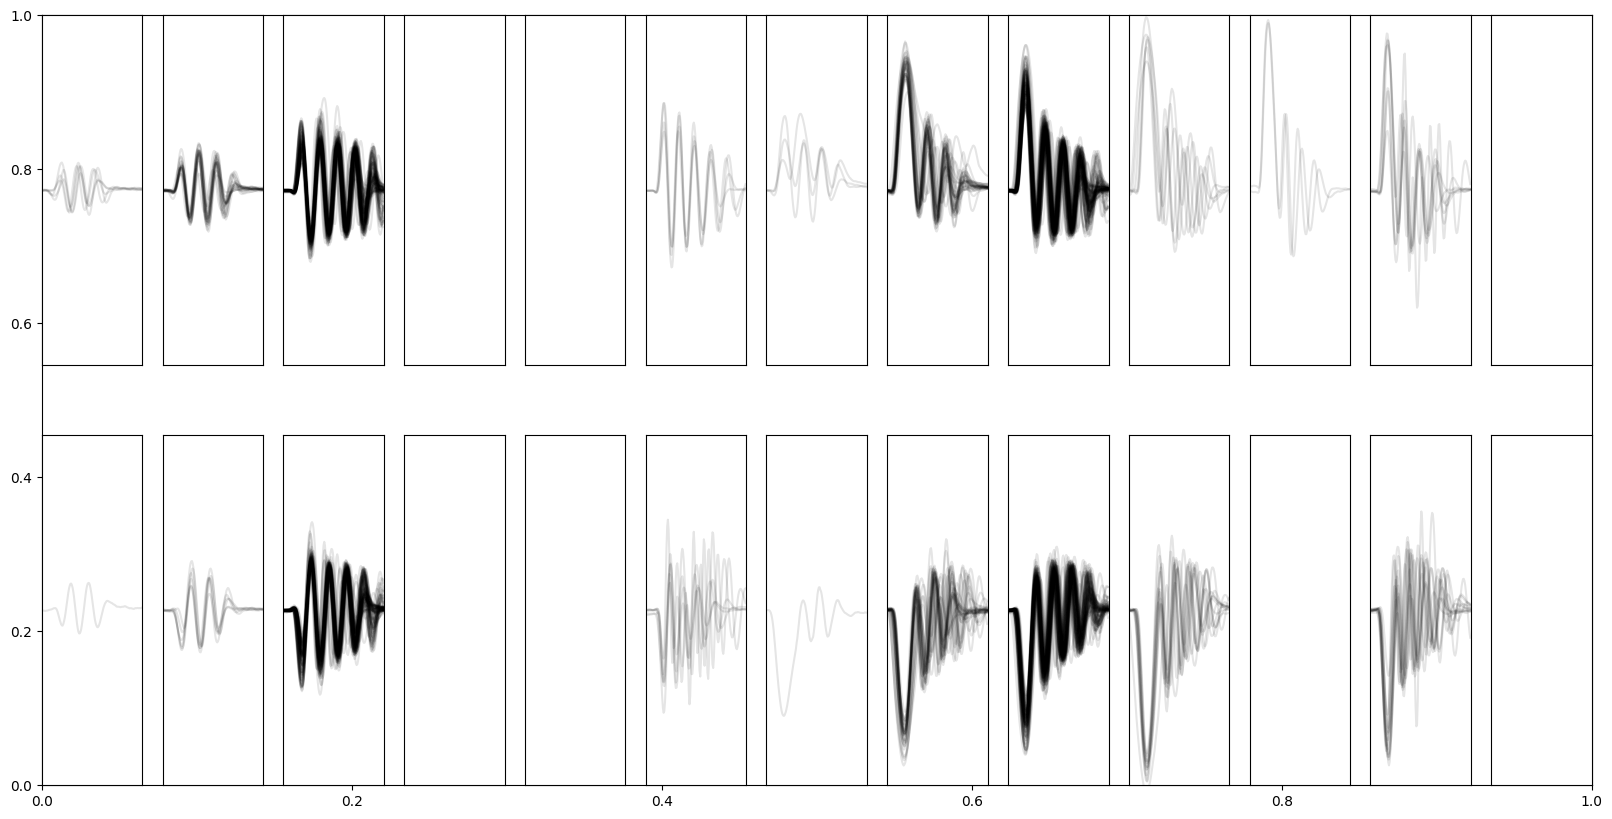

In [30]:
import matplotlib.gridspec as gridspec

fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 
G = gridspec.GridSpec(2,13)
ax0 = {}
for b in range(13):
    for i_sg,sg in enumerate([1,-1]):        
        ax0 = plt.subplot(G[i_sg,b])
        #ax0.set_title(NameCat[b%11])
        id = bouts.df[(bouts.df.label.category==b) & (bouts.df.label.sign==sg) & (bouts.df.label.proba>0.8)].index
        if len(id)>0:
            id = id[0:100]
            ax0.plot(tail_array[id,7,:].T,'k',alpha=.1)
        ax0.set_xlim(0,tail_segmentation_cfg.bout_duration)
        ax0.set_ylim(-3.8,3.8)
        ax0.set_xticks([])
        ax0.set_yticks([])
    
plt.show()